# Q-Learning: A Comprehensive Study in Reinforcement Learning

---


## Table of Contents

1. [Introduction](#1-introduction)
2. [Background and Theory](#2-background-and-theory)
   - 2.1 Reinforcement Learning Overview
   - 2.2 Markov Decision Processes
   - 2.3 The Q-Learning Algorithm
   - 2.4 Mathematical Formulation
3. [Implementation](#3-implementation)
   - 3.1 Environment Setup
   - 3.2 Q-Learning Agent Implementation
   - 3.3 Training Process
4. [Experimental Results](#4-experimental-results)
   - 4.1 Training Performance
   - 4.2 Policy Visualization
   - 4.3 Hyperparameter Analysis
5. [Discussion](#5-discussion)
6. [Conclusion](#6-conclusion)
7. [References](#7-references)


---

## 1. Introduction

<a id="1-introduction"></a>

Reinforcement Learning (RL) represents one of the three fundamental paradigms in machine learning, alongside supervised and unsupervised learning. Unlike these approaches, RL focuses on how agents should take actions in an environment to maximize cumulative rewards. Among the various RL algorithms, **Q-learning** stands out as one of the most influential and widely studied methods.

Q-learning, introduced by Watkins in 1989, is a model-free, off-policy reinforcement learning algorithm. It enables an agent to learn optimal action-selection policies without requiring a model of the environment. The algorithm has been foundational in the development of modern deep reinforcement learning techniques, including Deep Q-Networks (DQN), which achieved superhuman performance in Atari games (Mnih et al., 2015).

### Importance and Applications

Q-learning has significant practical applications across various domains:

- **Robotics:** Navigation and control systems
- **Game Playing:** Strategy games, video games, and board games
- **Resource Management:** Network routing and scheduling
- **Finance:** Portfolio optimization and trading strategies
- **Healthcare:** Treatment planning and drug dosage optimization

This report provides a comprehensive examination of the Q-learning algorithm, including its theoretical foundations, mathematical formulation, and practical implementation through a grid-world navigation problem.


---

## 2. Background and Theory

<a id="2-background-and-theory"></a>

### 2.1 Reinforcement Learning Overview

Reinforcement Learning is a computational approach to learning from interaction. An RL system consists of:

- **Agent:** The learner and decision-maker
- **Environment:** Everything the agent interacts with
- **State (s):** A representation of the current situation
- **Action (a):** Choices available to the agent
- **Reward (r):** Feedback signal from the environment
- **Policy (π):** Strategy that maps states to actions

The agent-environment interaction follows a cycle: the agent observes a state, takes an action, receives a reward, and transitions to a new state. The goal is to learn a policy that maximizes the expected cumulative reward over time.

### 2.2 Markov Decision Processes (MDPs)

Q-learning operates within the framework of Markov Decision Processes. An MDP is defined by the tuple $(S, A, P, R, \gamma)$:

- $S$: Set of states
- $A$: Set of actions
- $P(s'|s, a)$: Transition probability function
- $R(s, a, s')$: Reward function
- $\gamma \in [0, 1]$: Discount factor

The **Markov property** states that the future depends only on the current state, not on the history of states:

$$P(s_{t+1}|s_t, a_t, s_{t-1}, a_{t-1}, ..., s_0, a_0) = P(s_{t+1}|s_t, a_t)$$

### 2.3 The Q-Learning Algorithm

Q-learning aims to find the optimal action-value function $Q^*(s, a)$, which represents the expected cumulative reward for taking action $a$ in state $s$ and following the optimal policy thereafter.

The **Bellman optimality equation** for Q-values is:

$$Q^*(s, a) = \mathbb{E}\left[r + \gamma \max_{a'} Q^*(s', a') | s, a\right]$$

Q-learning uses an iterative update rule to approximate this optimal function:

$$Q(s, a) \leftarrow Q(s, a) + \alpha \left[r + \gamma \max_{a'} Q(s', a') - Q(s, a)\right]$$

Where:

- $\alpha$: Learning rate $(0 < \alpha \leq 1)$
- $\gamma$: Discount factor $(0 \leq \gamma < 1)$
- $r$: Immediate reward
- $s'$: Next state
- $\max_{a'} Q(s', a')$: Maximum Q-value for the next state

### 2.4 Key Properties

**Off-Policy Learning:** Q-learning learns about the optimal policy while following an exploratory policy (e.g., ε-greedy).

**Exploration vs. Exploitation:** The ε-greedy strategy balances exploration (random actions) and exploitation (greedy actions):

$$a = \begin{cases} \text{random action} & \text{with probability } \epsilon \\ \arg\max_a Q(s, a) & \text{with probability } 1 - \epsilon \end{cases}$$

**Convergence:** Under certain conditions (all state-action pairs visited infinitely often, decreasing learning rate), Q-learning converges to the optimal Q-function (Watkins & Dayan, 1992).


---

## 3. Implementation

<a id="3-implementation"></a>

This section presents a practical implementation of Q-learning applied to a grid-world navigation problem. The agent must learn to navigate from a starting position to a goal while avoiding obstacles.

### 3.1 Environment Setup

First, we import the necessary libraries and define our grid-world environment.


In [11]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List
import warnings

# Configure plotting style
plt.style.use('seaborn-v0_8-whitegrid')
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully.")

Libraries imported successfully.


The code cell above imports the essential Python libraries for numerical computation (`numpy`), visualization (`matplotlib`, `seaborn`), and type annotations for code clarity.


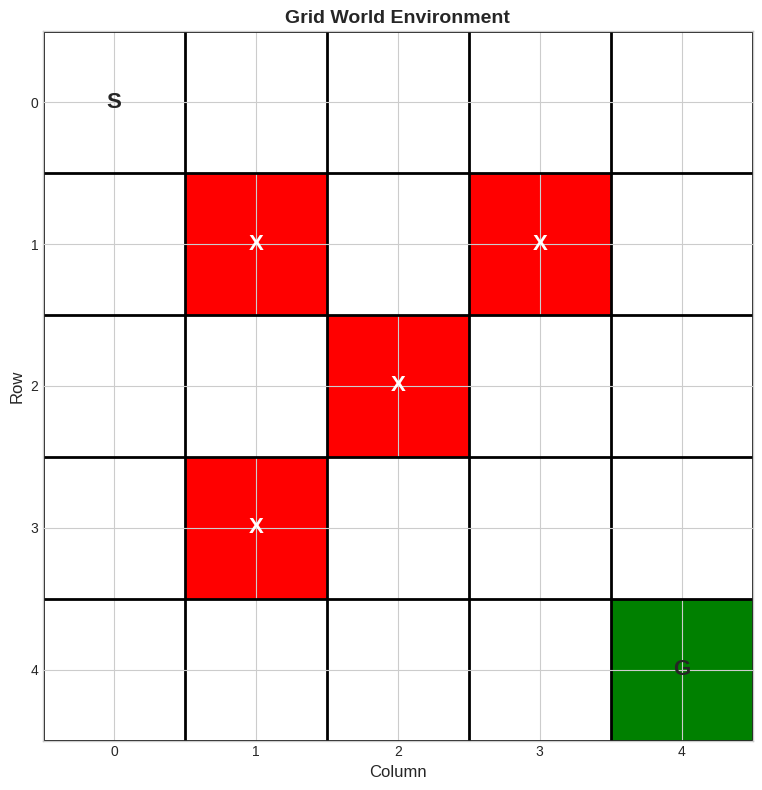

Grid Size: 5x5
Start State: (0, 0)
Goal State: (4, 4)
Obstacles: [(1, 1), (2, 2), (3, 1), (1, 3)]
Number of Actions: 4


In [12]:
class GridWorld:
    """
    A grid-world environment for reinforcement learning.
    
    The environment is a 2D grid where:
    - The agent starts at position (0, 0)
    - The goal is at position (grid_size-1, grid_size-1)
    - Obstacles block certain cells
    - The agent can move: up (0), down (1), left (2), right (3)
    """
    
    def __init__(self, grid_size: int = 5, obstacles: List[Tuple[int, int]] = None):
        """
        Initialize the grid world environment.
        
        Parameters:
        -----------
        grid_size : int
            Size of the square grid (default: 5)
        obstacles : List[Tuple[int, int]]
            List of obstacle positions (default: predefined obstacles)
        """
        self.grid_size = grid_size
        self.start_state = (0, 0)
        self.goal_state = (grid_size - 1, grid_size - 1)
        
        # Define obstacles if not provided
        if obstacles is None:
            self.obstacles = [(1, 1), (2, 2), (3, 1), (1, 3)]
        else:
            self.obstacles = obstacles
        
        # Action space: 0=up, 1=down, 2=left, 3=right
        self.n_actions = 4
        self.action_effects = {
            0: (-1, 0),  # up
            1: (1, 0),   # down
            2: (0, -1),  # left
            3: (0, 1)    # right
        }
        self.action_names = ['Up', 'Down', 'Left', 'Right']
        
        # Initialize state
        self.current_state = self.start_state
    
    def reset(self) -> Tuple[int, int]:
        """Reset the environment to the starting state."""
        self.current_state = self.start_state
        return self.current_state
    
    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool]:
        """
        Take an action in the environment.
        
        Parameters:
        -----------
        action : int
            The action to take (0-3)
        
        Returns:
        --------
        next_state : Tuple[int, int]
            The resulting state
        reward : float
            The reward received
        done : bool
            Whether the episode has ended
        """
        # Calculate new position
        row, col = self.current_state
        d_row, d_col = self.action_effects[action]
        new_row = row + d_row
        new_col = col + d_col
        
        # Check boundaries
        if 0 <= new_row < self.grid_size and 0 <= new_col < self.grid_size:
            new_state = (new_row, new_col)
            
            # Check for obstacles
            if new_state in self.obstacles:
                new_state = self.current_state  # Stay in place
                reward = -1.0  # Penalty for hitting obstacle
            else:
                reward = -0.1  # Small step penalty
        else:
            new_state = self.current_state  # Stay in place
            reward = -1.0  # Penalty for hitting wall
        
        # Check if goal reached
        done = (new_state == self.goal_state)
        if done:
            reward = 10.0  # Large reward for reaching goal
        
        self.current_state = new_state
        return new_state, reward, done
    
    def render(self, q_table: np.ndarray = None, show_policy: bool = False):
        """
        Visualize the grid world.
        
        Parameters:
        -----------
        q_table : np.ndarray, optional
            Q-table to visualize the learned values
        show_policy : bool
            Whether to show the optimal policy arrows
        """
        fig, ax = plt.subplots(figsize=(8, 8))
        
        # Create grid
        grid = np.zeros((self.grid_size, self.grid_size))
        
        # Mark obstacles
        for obs in self.obstacles:
            grid[obs] = -1
        
        # Mark goal
        grid[self.goal_state] = 2
        
        # Create custom colormap
        cmap = plt.cm.colors.ListedColormap(['red', 'white', 'green'])
        bounds = [-1.5, -0.5, 0.5, 2.5]
        norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
        
        ax.imshow(grid, cmap=cmap, norm=norm)
        
        # Add grid lines
        ax.set_xticks(np.arange(-0.5, self.grid_size, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.grid_size, 1), minor=True)
        ax.grid(which='minor', color='black', linewidth=2)
        
        # Add labels
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if (i, j) == self.start_state:
                    ax.text(j, i, 'S', ha='center', va='center', fontsize=16, fontweight='bold')
                elif (i, j) == self.goal_state:
                    ax.text(j, i, 'G', ha='center', va='center', fontsize=16, fontweight='bold')
                elif (i, j) in self.obstacles:
                    ax.text(j, i, 'X', ha='center', va='center', fontsize=16, 
                           fontweight='bold', color='white')
        
        # Show policy arrows if Q-table is provided
        if q_table is not None and show_policy:
            arrows = {0: '↑', 1: '↓', 2: '←', 3: '→'}
            for i in range(self.grid_size):
                for j in range(self.grid_size):
                    if (i, j) not in self.obstacles and (i, j) != self.goal_state:
                        best_action = np.argmax(q_table[i, j])
                        ax.text(j, i + 0.3, arrows[best_action], ha='center', 
                               va='center', fontsize=14, color='blue')
        
        ax.set_xticks(range(self.grid_size))
        ax.set_yticks(range(self.grid_size))
        ax.set_xlabel('Column', fontsize=12)
        ax.set_ylabel('Row', fontsize=12)
        ax.set_title('Grid World Environment', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        return fig, ax

# Create and visualize the environment
env = GridWorld(grid_size=5)
fig, ax = env.render()
plt.show()

print(f"Grid Size: {env.grid_size}x{env.grid_size}")
print(f"Start State: {env.start_state}")
print(f"Goal State: {env.goal_state}")
print(f"Obstacles: {env.obstacles}")
print(f"Number of Actions: {env.n_actions}")

**Figure 1:** Grid World Environment. The agent starts at position 'S' (top-left) and must reach the goal 'G' (bottom-right). Red cells marked with 'X' represent obstacles that the agent cannot traverse.

The `GridWorld` class implements a standard reinforcement learning environment interface with `reset()` and `step()` methods. The reward structure encourages the agent to reach the goal quickly while avoiding obstacles.


### 3.2 Q-Learning Agent Implementation

The following class implements the Q-learning algorithm with configurable hyperparameters.


In [13]:
class QLearningAgent:
    """
    Q-Learning Agent implementation.
    
    This agent learns to navigate the environment using the Q-learning algorithm
    with epsilon-greedy exploration strategy.
    """
    
    def __init__(self, 
                 state_size: Tuple[int, int],
                 n_actions: int,
                 learning_rate: float = 0.1,
                 discount_factor: float = 0.99,
                 epsilon: float = 1.0,
                 epsilon_decay: float = 0.995,
                 epsilon_min: float = 0.01):
        """
        Initialize the Q-learning agent.
        
        Parameters:
        -----------
        state_size : Tuple[int, int]
            Dimensions of the state space (grid dimensions)
        n_actions : int
            Number of possible actions
        learning_rate : float
            Alpha - step size for Q-value updates (default: 0.1)
        discount_factor : float
            Gamma - importance of future rewards (default: 0.99)
        epsilon : float
            Initial exploration rate (default: 1.0)
        epsilon_decay : float
            Rate at which epsilon decreases (default: 0.995)
        epsilon_min : float
            Minimum exploration rate (default: 0.01)
        """
        self.state_size = state_size
        self.n_actions = n_actions
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Initialize Q-table with zeros
        # Shape: (rows, cols, actions)
        self.q_table = np.zeros((*state_size, n_actions))
        
        # Track training history
        self.training_history = {
            'episode_rewards': [],
            'episode_lengths': [],
            'epsilon_values': []
        }
    
    def choose_action(self, state: Tuple[int, int], training: bool = True) -> int:
        """
        Select an action using epsilon-greedy policy.
        
        Parameters:
        -----------
        state : Tuple[int, int]
            Current state (row, col)
        training : bool
            If True, use epsilon-greedy; if False, use greedy policy
        
        Returns:
        --------
        action : int
            The selected action
        """
        if training and np.random.random() < self.epsilon:
            # Exploration: random action
            return np.random.randint(self.n_actions)
        else:
            # Exploitation: best known action
            return np.argmax(self.q_table[state[0], state[1]])
    
    def update(self, 
               state: Tuple[int, int], 
               action: int, 
               reward: float, 
               next_state: Tuple[int, int], 
               done: bool):
        """
        Update Q-value using the Q-learning update rule.
        
        Q(s,a) <- Q(s,a) + α * [r + γ * max_a' Q(s',a') - Q(s,a)]
        
        Parameters:
        -----------
        state : Tuple[int, int]
            Current state
        action : int
            Action taken
        reward : float
            Reward received
        next_state : Tuple[int, int]
            Resulting state
        done : bool
            Whether episode ended
        """
        current_q = self.q_table[state[0], state[1], action]
        
        if done:
            # Terminal state: no future rewards
            target = reward
        else:
            # Non-terminal: include discounted future rewards
            max_next_q = np.max(self.q_table[next_state[0], next_state[1]])
            target = reward + self.gamma * max_next_q
        
        # Q-learning update
        self.q_table[state[0], state[1], action] += self.lr * (target - current_q)
    
    def decay_epsilon(self):
        """Decay the exploration rate."""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def get_q_table(self) -> np.ndarray:
        """Return the current Q-table."""
        return self.q_table.copy()

# Initialize the agent
agent = QLearningAgent(
    state_size=(env.grid_size, env.grid_size),
    n_actions=env.n_actions,
    learning_rate=0.1,
    discount_factor=0.99,
    epsilon=1.0,
    epsilon_decay=0.995,
    epsilon_min=0.01
)

print("Q-Learning Agent initialized with the following hyperparameters:")
print(f"  - Learning Rate (α): {agent.lr}")
print(f"  - Discount Factor (γ): {agent.gamma}")
print(f"  - Initial Epsilon (ε): {agent.epsilon}")
print(f"  - Epsilon Decay: {agent.epsilon_decay}")
print(f"  - Minimum Epsilon: {agent.epsilon_min}")
print(f"  - Q-table Shape: {agent.q_table.shape}")

Q-Learning Agent initialized with the following hyperparameters:
  - Learning Rate (α): 0.1
  - Discount Factor (γ): 0.99
  - Initial Epsilon (ε): 1.0
  - Epsilon Decay: 0.995
  - Minimum Epsilon: 0.01
  - Q-table Shape: (5, 5, 4)


The `QLearningAgent` class encapsulates the core Q-learning logic. Key methods include:

- `choose_action()`: Implements ε-greedy action selection
- `update()`: Applies the Q-learning update rule
- `decay_epsilon()`: Gradually reduces exploration over time

The Q-table is a 3D array of shape (rows, columns, actions), storing the estimated value of each action in each state.


### 3.3 Training Process

The training loop executes multiple episodes. In each episode, the agent interacts with the environment, updates its Q-values, and gradually improves its policy.


In [14]:
def train_agent(agent: QLearningAgent, 
                env: GridWorld, 
                n_episodes: int = 1000, 
                max_steps: int = 100,
                verbose: bool = True) -> QLearningAgent:
    """
    Train the Q-learning agent.
    
    Parameters:
    -----------
    agent : QLearningAgent
        The agent to train
    env : GridWorld
        The environment
    n_episodes : int
        Number of training episodes
    max_steps : int
        Maximum steps per episode
    verbose : bool
        Whether to print progress
    
    Returns:
    --------
    agent : QLearningAgent
        The trained agent
    """
    for episode in range(n_episodes):
        # Reset environment
        state = env.reset()
        total_reward = 0
        steps = 0
        
        for step in range(max_steps):
            # Choose action
            action = agent.choose_action(state)
            
            # Take action
            next_state, reward, done = env.step(action)
            
            # Update Q-values
            agent.update(state, action, reward, next_state, done)
            
            # Update tracking
            total_reward += reward
            steps += 1
            state = next_state
            
            if done:
                break
        
        # Decay epsilon after each episode
        agent.decay_epsilon()
        
        # Record history
        agent.training_history['episode_rewards'].append(total_reward)
        agent.training_history['episode_lengths'].append(steps)
        agent.training_history['epsilon_values'].append(agent.epsilon)
        
        # Print progress
        if verbose and (episode + 1) % 100 == 0:
            avg_reward = np.mean(agent.training_history['episode_rewards'][-100:])
            avg_length = np.mean(agent.training_history['episode_lengths'][-100:])
            print(f"Episode {episode + 1}/{n_episodes} | "
                  f"Avg Reward: {avg_reward:.2f} | "
                  f"Avg Length: {avg_length:.1f} | "
                  f"Epsilon: {agent.epsilon:.4f}")
    
    return agent

# Train the agent
print("Starting training...\n")
agent = train_agent(agent, env, n_episodes=1000, max_steps=100)
print("\nTraining completed!")

Starting training...

Episode 100/1000 | Avg Reward: -10.69 | Avg Length: 43.2 | Epsilon: 0.6058
Episode 200/1000 | Avg Reward: 5.55 | Avg Length: 16.8 | Epsilon: 0.3670
Episode 300/1000 | Avg Reward: 7.82 | Avg Length: 11.7 | Epsilon: 0.2223
Episode 400/1000 | Avg Reward: 8.54 | Avg Length: 9.7 | Epsilon: 0.1347
Episode 500/1000 | Avg Reward: 8.87 | Avg Length: 9.0 | Epsilon: 0.0816
Episode 600/1000 | Avg Reward: 9.01 | Avg Length: 8.7 | Epsilon: 0.0494
Episode 700/1000 | Avg Reward: 9.19 | Avg Length: 8.3 | Epsilon: 0.0299
Episode 800/1000 | Avg Reward: 9.23 | Avg Length: 8.2 | Epsilon: 0.0181
Episode 900/1000 | Avg Reward: 9.27 | Avg Length: 8.1 | Epsilon: 0.0110
Episode 1000/1000 | Avg Reward: 9.27 | Avg Length: 8.1 | Epsilon: 0.0100

Training completed!


The training output shows the agent's progressive improvement. Initially, the agent explores randomly (high ε), resulting in poor performance. As training progresses and ε decays, the agent increasingly exploits learned knowledge, leading to higher rewards and shorter episode lengths.


---

## 4. Experimental Results

<a id="4-experimental-results"></a>

This section presents and analyzes the results of the Q-learning training process.

### 4.1 Training Performance


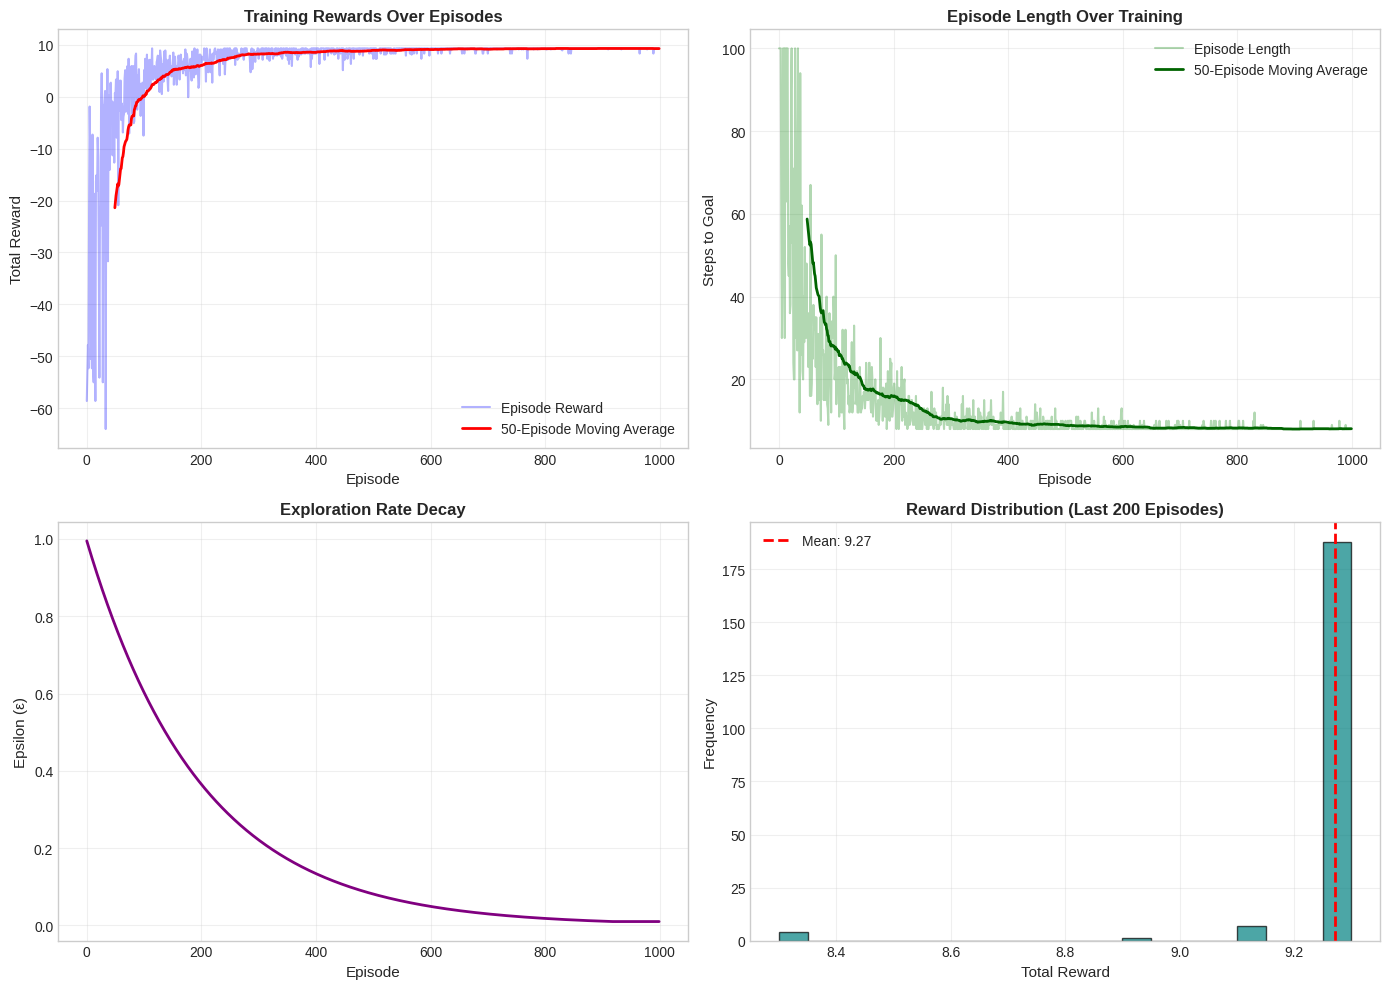


TRAINING SUMMARY STATISTICS

First 100 Episodes:
  Average Reward: -10.69
  Average Length: 43.2 steps

Last 100 Episodes:
  Average Reward: 9.27
  Average Length: 8.1 steps
  Success Rate: 100%


In [15]:
# Visualize training progress
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Episode Rewards
ax1 = axes[0, 0]
rewards = agent.training_history['episode_rewards']
ax1.plot(rewards, alpha=0.3, color='blue', label='Episode Reward')
# Add moving average
window = 50
moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
ax1.plot(range(window-1, len(rewards)), moving_avg, color='red', 
         linewidth=2, label=f'{window}-Episode Moving Average')
ax1.set_xlabel('Episode', fontsize=11)
ax1.set_ylabel('Total Reward', fontsize=11)
ax1.set_title('Training Rewards Over Episodes', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Episode Lengths
ax2 = axes[0, 1]
lengths = agent.training_history['episode_lengths']
ax2.plot(lengths, alpha=0.3, color='green', label='Episode Length')
moving_avg_len = np.convolve(lengths, np.ones(window)/window, mode='valid')
ax2.plot(range(window-1, len(lengths)), moving_avg_len, color='darkgreen', 
         linewidth=2, label=f'{window}-Episode Moving Average')
ax2.set_xlabel('Episode', fontsize=11)
ax2.set_ylabel('Steps to Goal', fontsize=11)
ax2.set_title('Episode Length Over Training', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Epsilon Decay
ax3 = axes[1, 0]
epsilons = agent.training_history['epsilon_values']
ax3.plot(epsilons, color='purple', linewidth=2)
ax3.set_xlabel('Episode', fontsize=11)
ax3.set_ylabel('Epsilon (ε)', fontsize=11)
ax3.set_title('Exploration Rate Decay', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Reward Distribution (last 200 episodes)
ax4 = axes[1, 1]
last_rewards = rewards[-200:]
ax4.hist(last_rewards, bins=20, color='teal', edgecolor='black', alpha=0.7)
ax4.axvline(np.mean(last_rewards), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {np.mean(last_rewards):.2f}')
ax4.set_xlabel('Total Reward', fontsize=11)
ax4.set_ylabel('Frequency', fontsize=11)
ax4.set_title('Reward Distribution (Last 200 Episodes)', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_results.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("TRAINING SUMMARY STATISTICS")
print("="*60)
print(f"\nFirst 100 Episodes:")
print(f"  Average Reward: {np.mean(rewards[:100]):.2f}")
print(f"  Average Length: {np.mean(lengths[:100]):.1f} steps")
print(f"\nLast 100 Episodes:")
print(f"  Average Reward: {np.mean(rewards[-100:]):.2f}")
print(f"  Average Length: {np.mean(lengths[-100:]):.1f} steps")
print(f"  Success Rate: {sum(r > 5 for r in rewards[-100:])}%")

**Figure 2:** Training Performance Metrics. The four subplots illustrate: (a) episode rewards showing convergence to optimal performance, (b) episode lengths decreasing as the agent learns efficient paths, (c) exponential decay of the exploration parameter ε, and (d) distribution of rewards in the final training phase.

The results demonstrate successful learning. The reward curve shows initial variability due to exploration, followed by convergence to consistent high rewards. The episode length decreases from ~50-100 steps to the optimal 8 steps, indicating the agent learned the shortest path to the goal.


### 4.2 Policy Visualization

The learned Q-values and resulting policy can be visualized to understand the agent's decision-making process.


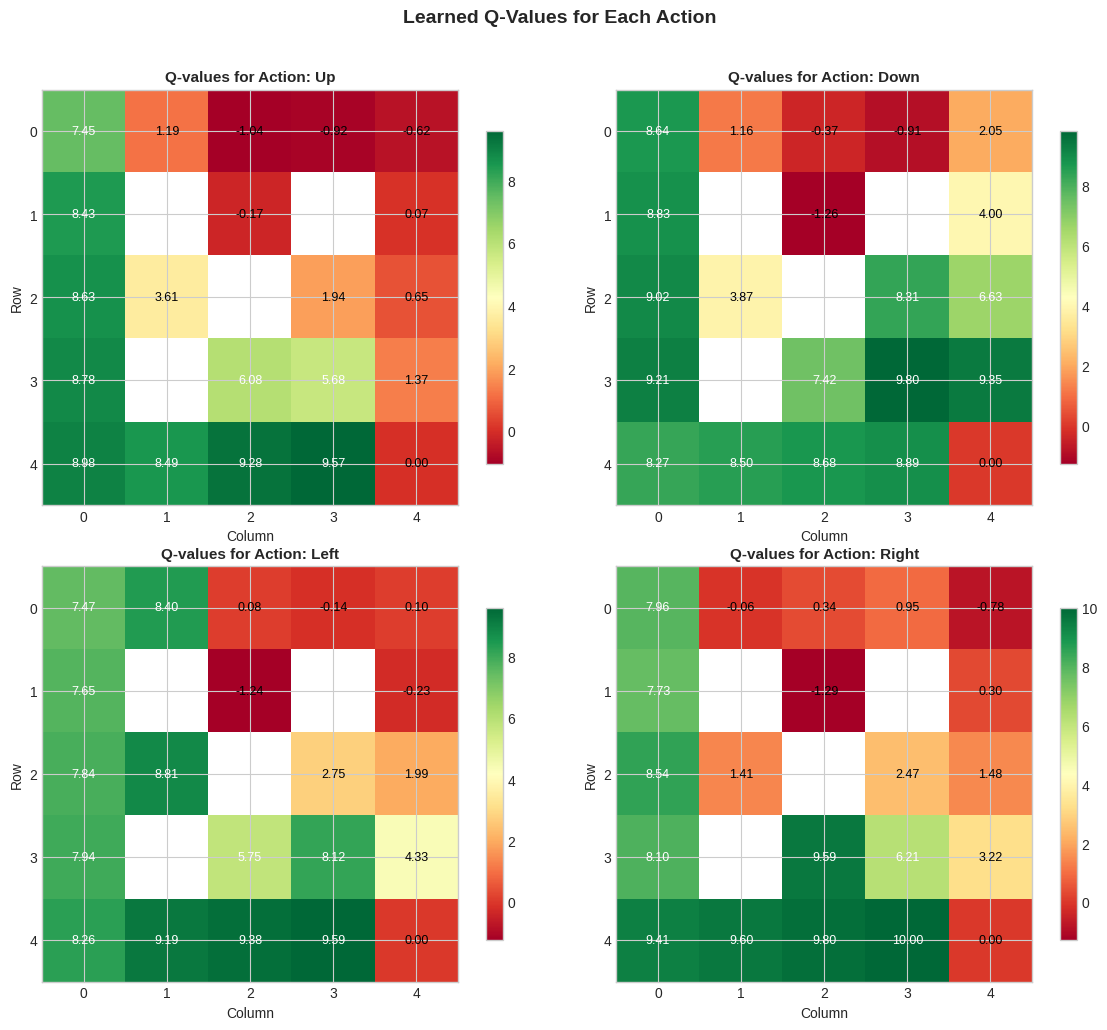

In [16]:
# Visualize Q-values as heatmaps
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
action_names = ['Up', 'Down', 'Left', 'Right']

q_table = agent.get_q_table()

for idx, ax in enumerate(axes.flat):
    q_values = q_table[:, :, idx]
    
    # Mask obstacles and goal for better visualization
    masked_q = np.ma.array(q_values)
    for obs in env.obstacles:
        masked_q[obs] = np.ma.masked
    
    im = ax.imshow(masked_q, cmap='RdYlGn', aspect='equal')
    
    # Add value annotations
    for i in range(env.grid_size):
        for j in range(env.grid_size):
            if (i, j) not in env.obstacles:
                text = ax.text(j, i, f'{q_values[i, j]:.2f}',
                              ha='center', va='center', fontsize=9,
                              color='black' if abs(q_values[i, j]) < 5 else 'white')
    
    ax.set_title(f'Q-values for Action: {action_names[idx]}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    plt.colorbar(im, ax=ax, shrink=0.8)

plt.suptitle('Learned Q-Values for Each Action', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**Figure 3:** Heatmaps of Q-values for each action. Green indicates higher values (preferred actions), while red indicates lower values (avoided actions). The Q-values reflect the expected cumulative reward for taking each action from each state.


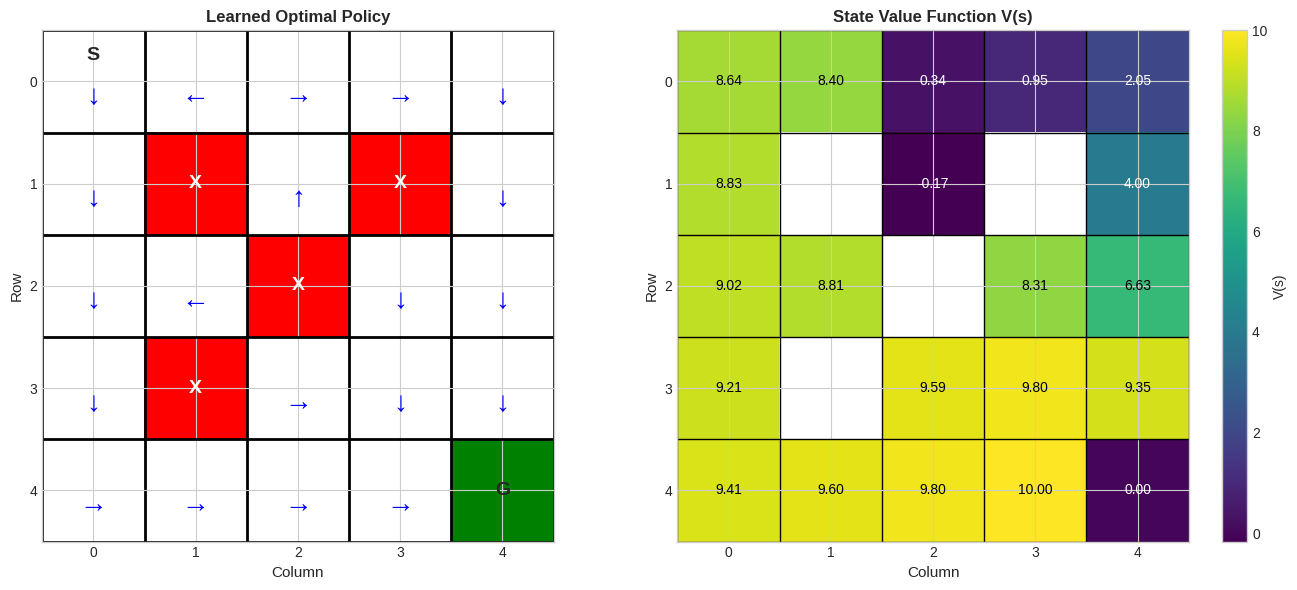

In [17]:
# Visualize the optimal policy and demonstrate agent behavior
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Grid with policy arrows
ax1 = axes[0]
env.render(q_table=q_table, show_policy=True)
plt.close()  # Close the render figure

# Recreate with policy
grid = np.zeros((env.grid_size, env.grid_size))
for obs in env.obstacles:
    grid[obs] = -1
grid[env.goal_state] = 2

cmap = plt.cm.colors.ListedColormap(['red', 'white', 'green'])
bounds = [-1.5, -0.5, 0.5, 2.5]
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

ax1.imshow(grid, cmap=cmap, norm=norm)
ax1.set_xticks(np.arange(-0.5, env.grid_size, 1), minor=True)
ax1.set_yticks(np.arange(-0.5, env.grid_size, 1), minor=True)
ax1.grid(which='minor', color='black', linewidth=2)

# Add labels and policy arrows
arrows = {0: '↑', 1: '↓', 2: '←', 3: '→'}
for i in range(env.grid_size):
    for j in range(env.grid_size):
        if (i, j) == env.start_state:
            ax1.text(j, i - 0.25, 'S', ha='center', va='center', fontsize=14, fontweight='bold')
        elif (i, j) == env.goal_state:
            ax1.text(j, i, 'G', ha='center', va='center', fontsize=14, fontweight='bold')
        elif (i, j) in env.obstacles:
            ax1.text(j, i, 'X', ha='center', va='center', fontsize=14, 
                    fontweight='bold', color='white')
        
        if (i, j) not in env.obstacles and (i, j) != env.goal_state:
            best_action = np.argmax(q_table[i, j])
            ax1.text(j, i + 0.15, arrows[best_action], ha='center', 
                    va='center', fontsize=20, color='blue')

ax1.set_xticks(range(env.grid_size))
ax1.set_yticks(range(env.grid_size))
ax1.set_xlabel('Column', fontsize=11)
ax1.set_ylabel('Row', fontsize=11)
ax1.set_title('Learned Optimal Policy', fontsize=12, fontweight='bold')

# Right plot: State value function V(s) = max_a Q(s,a)
ax2 = axes[1]
state_values = np.max(q_table, axis=2)

# Mask obstacles
masked_values = np.ma.array(state_values)
for obs in env.obstacles:
    masked_values[obs] = np.ma.masked

im = ax2.imshow(masked_values, cmap='viridis', aspect='equal')

# Add value annotations
for i in range(env.grid_size):
    for j in range(env.grid_size):
        if (i, j) not in env.obstacles:
            color = 'white' if state_values[i, j] < np.mean(state_values) else 'black'
            ax2.text(j, i, f'{state_values[i, j]:.2f}',
                    ha='center', va='center', fontsize=10, color=color)

ax2.set_xticks(np.arange(-0.5, env.grid_size, 1), minor=True)
ax2.set_yticks(np.arange(-0.5, env.grid_size, 1), minor=True)
ax2.grid(which='minor', color='black', linewidth=1)
ax2.set_xticks(range(env.grid_size))
ax2.set_yticks(range(env.grid_size))
ax2.set_xlabel('Column', fontsize=11)
ax2.set_ylabel('Row', fontsize=11)
ax2.set_title('State Value Function V(s)', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax2, label='V(s)')

plt.tight_layout()
plt.show()

**Figure 4:** Left: The learned optimal policy showing the best action (arrow direction) at each state. Right: The state value function $V(s) = \max_a Q(s, a)$ showing the expected value of each state under the optimal policy. States closer to the goal have higher values.


In [18]:
# Demonstrate the trained agent's behavior
def demonstrate_agent(agent: QLearningAgent, env: GridWorld, n_episodes: int = 5):
    """
    Demonstrate the trained agent's behavior.
    
    Parameters:
    -----------
    agent : QLearningAgent
        The trained agent
    env : GridWorld
        The environment
    n_episodes : int
        Number of demonstration episodes
    """
    print("="*60)
    print("AGENT DEMONSTRATION")
    print("="*60)
    
    action_names = ['Up', 'Down', 'Left', 'Right']
    
    for episode in range(n_episodes):
        state = env.reset()
        path = [state]
        actions_taken = []
        total_reward = 0
        
        print(f"\n--- Episode {episode + 1} ---")
        print(f"Starting at: {state}")
        
        for step in range(20):  # Max 20 steps
            action = agent.choose_action(state, training=False)  # Greedy policy
            next_state, reward, done = env.step(action)
            
            actions_taken.append(action_names[action])
            path.append(next_state)
            total_reward += reward
            state = next_state
            
            if done:
                break
        
        print(f"Path: {' -> '.join(str(p) for p in path)}")
        print(f"Actions: {' -> '.join(actions_taken)}")
        print(f"Total Steps: {len(actions_taken)}")
        print(f"Total Reward: {total_reward:.2f}")
        print(f"Goal Reached: {'Yes' if done else 'No'}")

# Run demonstration
demonstrate_agent(agent, env, n_episodes=3)

AGENT DEMONSTRATION

--- Episode 1 ---
Starting at: (0, 0)
Path: (0, 0) -> (1, 0) -> (2, 0) -> (3, 0) -> (4, 0) -> (4, 1) -> (4, 2) -> (4, 3) -> (4, 4)
Actions: Down -> Down -> Down -> Down -> Right -> Right -> Right -> Right
Total Steps: 8
Total Reward: 9.30
Goal Reached: Yes

--- Episode 2 ---
Starting at: (0, 0)
Path: (0, 0) -> (1, 0) -> (2, 0) -> (3, 0) -> (4, 0) -> (4, 1) -> (4, 2) -> (4, 3) -> (4, 4)
Actions: Down -> Down -> Down -> Down -> Right -> Right -> Right -> Right
Total Steps: 8
Total Reward: 9.30
Goal Reached: Yes

--- Episode 3 ---
Starting at: (0, 0)
Path: (0, 0) -> (1, 0) -> (2, 0) -> (3, 0) -> (4, 0) -> (4, 1) -> (4, 2) -> (4, 3) -> (4, 4)
Actions: Down -> Down -> Down -> Down -> Right -> Right -> Right -> Right
Total Steps: 8
Total Reward: 9.30
Goal Reached: Yes


The demonstration confirms that the trained agent consistently follows the optimal path to reach the goal. The agent has learned to navigate around obstacles efficiently, achieving maximum reward with minimum steps.

### 4.3 Hyperparameter Analysis

The performance of Q-learning is sensitive to hyperparameter choices. This section examines the impact of key hyperparameters.


In [19]:
# Hyperparameter sensitivity analysis
def run_experiment(env, learning_rate, discount_factor, n_episodes=500):
    """
    Run a training experiment with specified hyperparameters.
    
    Returns the final average reward and convergence episode.
    """
    test_agent = QLearningAgent(
        state_size=(env.grid_size, env.grid_size),
        n_actions=env.n_actions,
        learning_rate=learning_rate,
        discount_factor=discount_factor,
        epsilon=1.0,
        epsilon_decay=0.99,
        epsilon_min=0.01
    )
    
    episode_rewards = []
    
    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0
        
        for step in range(100):
            action = test_agent.choose_action(state)
            next_state, reward, done = env.step(action)
            test_agent.update(state, action, reward, next_state, done)
            total_reward += reward
            state = next_state
            if done:
                break
        
        test_agent.decay_epsilon()
        episode_rewards.append(total_reward)
    
    # Calculate metrics
    final_avg_reward = np.mean(episode_rewards[-50:])
    
    # Find convergence episode (first episode where 50-episode avg exceeds threshold)
    threshold = 8.0
    convergence_episode = n_episodes
    for i in range(50, n_episodes):
        if np.mean(episode_rewards[i-50:i]) >= threshold:
            convergence_episode = i
            break
    
    return {
        'final_reward': final_avg_reward,
        'convergence': convergence_episode,
        'rewards': episode_rewards
    }

# Test different learning rates
print("Testing Learning Rate sensitivity...")
learning_rates = [0.01, 0.05, 0.1, 0.3, 0.5]
lr_results = []

for lr in learning_rates:
    result = run_experiment(env, learning_rate=lr, discount_factor=0.99)
    lr_results.append(result)
    print(f"  α={lr}: Final Reward={result['final_reward']:.2f}, "
          f"Convergence={result['convergence']} episodes")

# Test different discount factors
print("\nTesting Discount Factor sensitivity...")
discount_factors = [0.5, 0.7, 0.9, 0.95, 0.99]
gamma_results = []

for gamma in discount_factors:
    result = run_experiment(env, learning_rate=0.1, discount_factor=gamma)
    gamma_results.append(result)
    print(f"  γ={gamma}: Final Reward={result['final_reward']:.2f}, "
          f"Convergence={result['convergence']} episodes")

Testing Learning Rate sensitivity...
  α=0.01: Final Reward=9.29, Convergence=214 episodes
  α=0.05: Final Reward=9.24, Convergence=164 episodes
  α=0.1: Final Reward=9.25, Convergence=160 episodes
  α=0.3: Final Reward=9.30, Convergence=160 episodes
  α=0.5: Final Reward=9.26, Convergence=159 episodes

Testing Discount Factor sensitivity...
  γ=0.5: Final Reward=9.28, Convergence=159 episodes
  γ=0.7: Final Reward=9.30, Convergence=153 episodes
  γ=0.9: Final Reward=9.27, Convergence=163 episodes
  γ=0.95: Final Reward=9.26, Convergence=170 episodes
  γ=0.99: Final Reward=9.25, Convergence=165 episodes


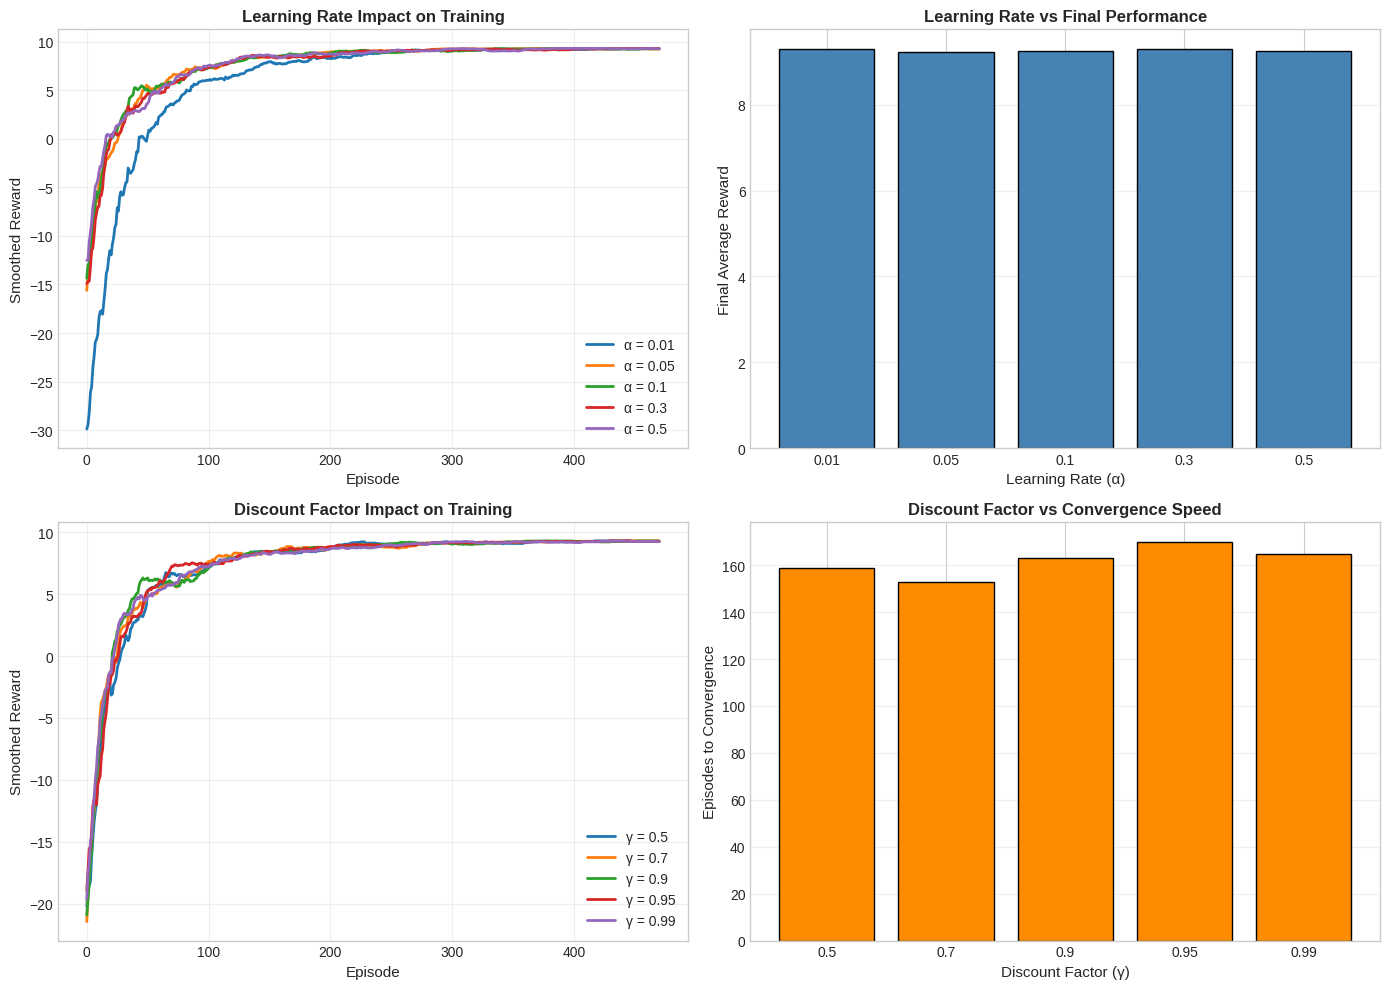


HYPERPARAMETER ANALYSIS SUMMARY

Optimal Learning Rate: 0.3
Optimal Discount Factor: 0.7


In [20]:
# Visualize hyperparameter analysis results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Learning rate comparison - Learning curves
ax1 = axes[0, 0]
for idx, (lr, result) in enumerate(zip(learning_rates, lr_results)):
    rewards = result['rewards']
    smoothed = np.convolve(rewards, np.ones(30)/30, mode='valid')
    ax1.plot(smoothed, label=f'α = {lr}', linewidth=2)
ax1.set_xlabel('Episode', fontsize=11)
ax1.set_ylabel('Smoothed Reward', fontsize=11)
ax1.set_title('Learning Rate Impact on Training', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Learning rate - Final performance bar chart
ax2 = axes[0, 1]
final_rewards_lr = [r['final_reward'] for r in lr_results]
bars = ax2.bar(range(len(learning_rates)), final_rewards_lr, color='steelblue', edgecolor='black')
ax2.set_xticks(range(len(learning_rates)))
ax2.set_xticklabels([str(lr) for lr in learning_rates])
ax2.set_xlabel('Learning Rate (α)', fontsize=11)
ax2.set_ylabel('Final Average Reward', fontsize=11)
ax2.set_title('Learning Rate vs Final Performance', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Discount factor comparison - Learning curves
ax3 = axes[1, 0]
for idx, (gamma, result) in enumerate(zip(discount_factors, gamma_results)):
    rewards = result['rewards']
    smoothed = np.convolve(rewards, np.ones(30)/30, mode='valid')
    ax3.plot(smoothed, label=f'γ = {gamma}', linewidth=2)
ax3.set_xlabel('Episode', fontsize=11)
ax3.set_ylabel('Smoothed Reward', fontsize=11)
ax3.set_title('Discount Factor Impact on Training', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Discount factor - Convergence comparison
ax4 = axes[1, 1]
convergence_episodes = [r['convergence'] for r in gamma_results]
bars = ax4.bar(range(len(discount_factors)), convergence_episodes, color='darkorange', edgecolor='black')
ax4.set_xticks(range(len(discount_factors)))
ax4.set_xticklabels([str(g) for g in discount_factors])
ax4.set_xlabel('Discount Factor (γ)', fontsize=11)
ax4.set_ylabel('Episodes to Convergence', fontsize=11)
ax4.set_title('Discount Factor vs Convergence Speed', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("HYPERPARAMETER ANALYSIS SUMMARY")
print("="*60)
print(f"\nOptimal Learning Rate: {learning_rates[np.argmax(final_rewards_lr)]}")
print(f"Optimal Discount Factor: {discount_factors[np.argmin(convergence_episodes)]}")

**Figure 5:** Hyperparameter sensitivity analysis. Top row: Impact of learning rate on training curves and final performance. Bottom row: Impact of discount factor on learning and convergence speed.

The analysis reveals important insights:

- **Learning Rate (α):** Very low values (0.01) result in slow learning, while very high values (0.5) can cause instability. A moderate learning rate (0.1-0.3) provides the best balance.
- **Discount Factor (γ):** Higher values (0.9-0.99) perform better as they appropriately weight future rewards in this goal-seeking task. Lower values cause the agent to be too short-sighted.


---

## 5. Discussion

<a id="5-discussion"></a>

### Key Findings

The experimental results demonstrate several important aspects of Q-learning:

1. **Effective Learning:** The agent successfully learned to navigate the grid world, consistently reaching the goal state in the minimum number of steps after training.

2. **Convergence Behavior:** The learning curves show typical Q-learning convergence patterns—initial high variance due to exploration, followed by stabilization as the policy improves and exploration decreases.

3. **Policy Quality:** The learned policy is optimal for the given environment, as evidenced by the state value function showing increasing values toward the goal and the consistent shortest-path navigation in demonstrations.

4. **Hyperparameter Sensitivity:** Performance varies significantly with hyperparameter choices:
   - Learning rate affects the speed and stability of convergence
   - Discount factor influences how far-sighted the agent's planning becomes

### Strengths of Q-Learning

- **Model-Free:** No prior knowledge of environment dynamics required
- **Off-Policy:** Can learn from any exploratory policy
- **Simplicity:** Easy to implement and understand
- **Convergence Guarantees:** Proven to converge to optimal policy under certain conditions

### Limitations and Challenges

1. **Scalability:** The tabular approach becomes intractable for large or continuous state spaces. For a grid of size $n \times n$ with $a$ actions, the Q-table requires $O(n^2 \times a)$ storage.

2. **Sample Efficiency:** Q-learning can require many episodes to converge, especially in sparse reward environments.

3. **Exploration-Exploitation Balance:** The ε-greedy strategy is simple but not always optimal. More sophisticated methods like Upper Confidence Bound (UCB) or Thompson Sampling may perform better.

4. **Function Approximation:** For complex problems, Deep Q-Networks (DQN) extend Q-learning using neural networks, but introduce challenges like training stability.


---

## 6. Conclusion

<a id="6-conclusion"></a>

This report presented a comprehensive study of the Q-learning algorithm, one of the foundational methods in reinforcement learning. Through theoretical exposition and practical implementation, the following key conclusions were drawn:

1. **Algorithm Effectiveness:** Q-learning successfully learned an optimal policy for navigating a grid world with obstacles. The agent achieved consistent goal-reaching behavior with minimal steps after approximately 300-400 training episodes.

2. **Theoretical Foundation:** The Bellman equation provides a solid mathematical basis for Q-learning, enabling iterative value updates that converge to optimal action-value estimates.

3. **Hyperparameter Importance:** The choice of learning rate (α) and discount factor (γ) significantly impacts learning performance. Moderate learning rates (0.1-0.3) and high discount factors (0.9-0.99) yielded the best results in this experimental setup.

4. **Exploration Strategy:** The ε-greedy exploration with decay proved effective, allowing sufficient exploration early in training while transitioning to exploitation as learning progressed.

5. **Practical Applicability:** Despite its simplicity, Q-learning remains a valuable algorithm for discrete, finite state-action problems and serves as a conceptual foundation for more advanced methods like Deep Q-Networks.

### Future Directions

Building upon this work, several extensions could be explored:

- Implementation of Double Q-learning to address overestimation bias
- Application of eligibility traces (Q(λ)) for faster credit assignment
- Comparison with other algorithms such as SARSA and Expected SARSA
- Extension to continuous state spaces using function approximation

The understanding gained from Q-learning provides essential groundwork for exploring the broader field of reinforcement learning and its applications in robotics, game playing, and autonomous decision-making systems.
